In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Data

In [8]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)

In [11]:
print(f"Min: {x_test.min()}, Max: {x_test.max()}")

Min: 0.0, Max: 1.0


# Model

In [ ]:
latent_dim = 2  # for easy visualization

# === Encoder ===
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# === Sampling ===
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === Decoder ===
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = layers.Reshape((28, 28, 1))(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# === VAE Model ===
z_mean_out, z_log_var_out, z_out = encoder(inputs)
reconstructed = decoder(z_out)
vae = Model(inputs, reconstructed, name="vae")

# === Loss Function ===
# VAE Loss=Reconstruction Loss+KL Divergence Loss

#Reconstruction Loss measures how well the decoder reconstructs the input from the latent vector.
reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(reconstructed))
reconstruction_loss *= 28 * 28
#KL Divergence Loss is a regularization term that encourages the encoder's output (latent distribution) to be close to a standard normal distribution
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var_out - tf.square(z_mean_out) - tf.exp(z_log_var_out), axis=1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

# === Train ===
vae.fit(x_train, x_train, epochs=30, batch_size=128)

# Generate New Digits from Latent Space

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


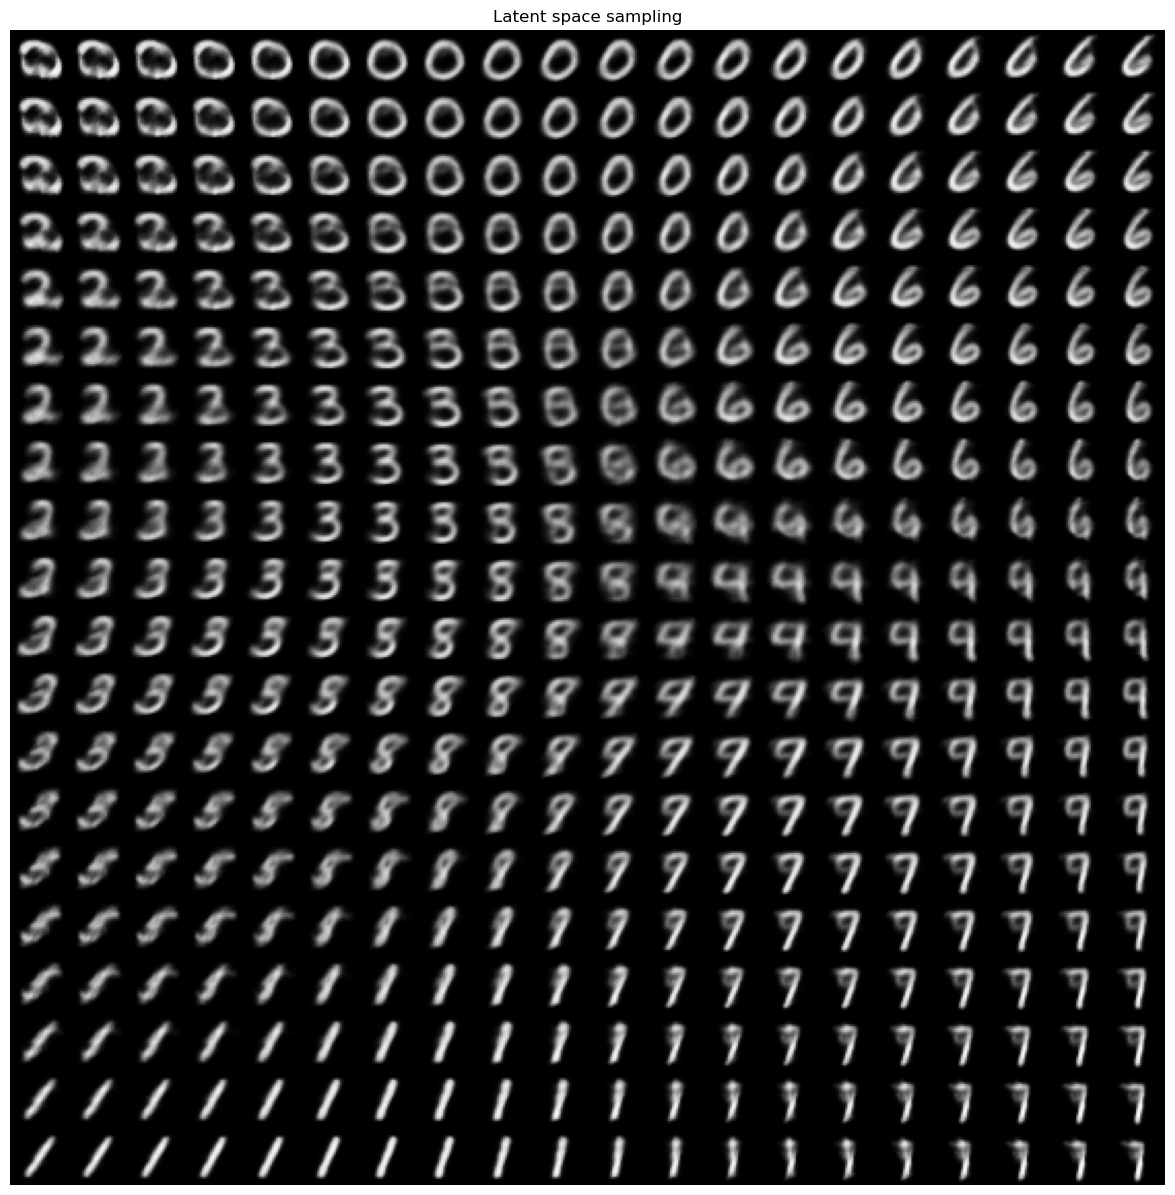

In [6]:
def plot_latent_grid(decoder, n=20, figsize=15):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-2, 2, n)   # ~95% of values fall within [−2, 2]
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size:(i + 1) * digit_size,
                   j * digit_size:(j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title('Latent space sampling')
    plt.show()

plot_latent_grid(decoder)